In [ ]:
# Oil Price Prediction - Model Deployment
# In this lab, we will deploy the best performing machine learning model
# to predict oil prices based on historical data and engineered features.
# We will use the dataset_11_86.csv dataset containing oil price data from 2012-2024.

# Import the necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('dataset_11_86.csv')

print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst 5 rows:")
print(df.head())

# Display descriptive statistics
print("\nDataset Info:")
print(df.info())
print("\nDescriptive Statistics:")
print(df.describe())

Dataset loaded successfully!
Dataset shape: (26746, 7)
Columns: ['Year', 'Month', 'Date', 'Item', 'Country', 'Price(Baht)', 'UNIT']

First 5 rows:
   Year    Month  Date         Item                          Country  \
0  2012  January    20    1033G-E10                      TH-THAILAND   
1  2012  January    20  1034-ULG 95                       BE-BELGIUM   
2  2012  January    20  1034-ULG 95  DE-GERAMANY,FEDERAL REPUBLIC OF   
3  2012  January    20  1034-ULG 95                        FR-FRANCE   
4  2012  January    20  1034-ULG 95                GB-UNITED KINGDOM   

   Price(Baht)        UNIT  
0    37.260000  BAHT/LITRE  
1    67.845196  BAHT/LITRE  
2    64.166842  BAHT/LITRE  
3    66.619078  BAHT/LITRE  
4    67.027784  BAHT/LITRE  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26746 entries, 0 to 26745
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         26746 non-null  int64

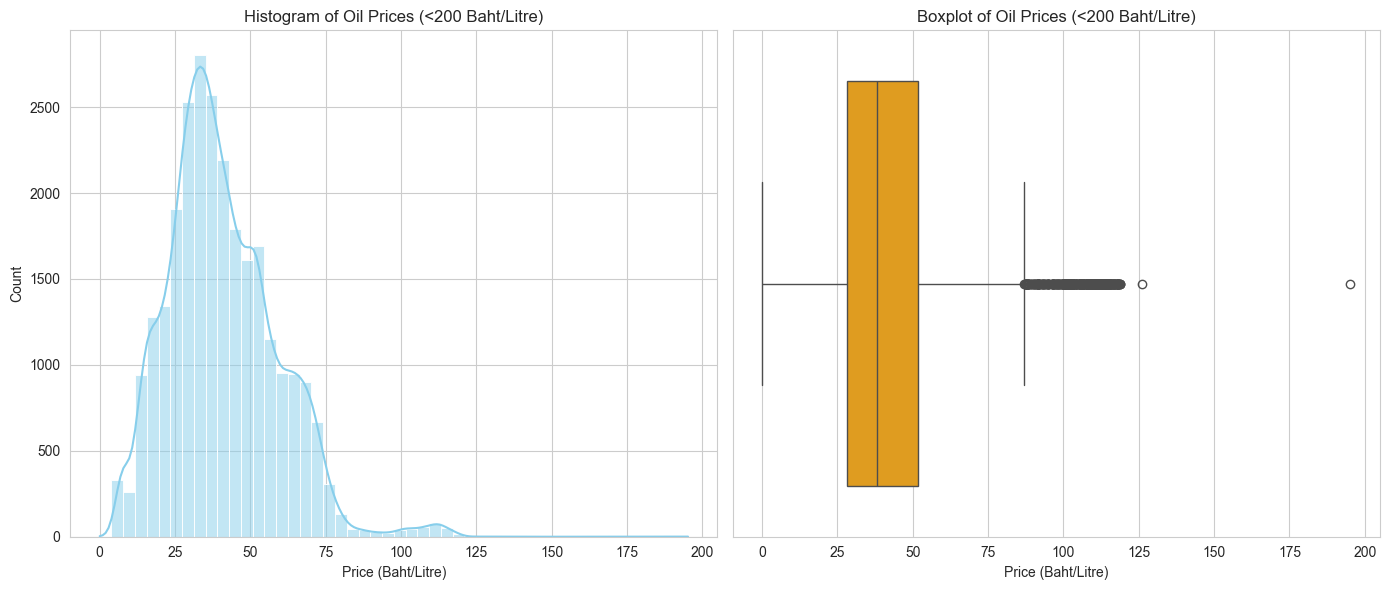

In [2]:
# %% [markdown]
# ## Zoom-in Visualization (Filter out extreme outliers)
# - ดูการกระจายเฉพาะราคาน้ำมัน < 200 บาท/ลิตร

# %%
plt.figure(figsize=(14,6))

# Filter เฉพาะค่าที่ต่ำกว่า 200
filtered = df[df["Price(Baht)"] < 200]

# Histogram
plt.subplot(1,2,1)
sns.histplot(filtered["Price(Baht)"], bins=50, kde=True, color="skyblue")
plt.title("Histogram of Oil Prices (<200 Baht/Litre)")
plt.xlabel("Price (Baht/Litre)")
plt.ylabel("Count")

# Boxplot
plt.subplot(1,2,2)
sns.boxplot(x=filtered["Price(Baht)"], color="orange")
plt.title("Boxplot of Oil Prices (<200 Baht/Litre)")
plt.xlabel("Price (Baht/Litre)")

plt.tight_layout()
plt.show()


Part 0 — Setup & สมมติฐานคอลัมน์

In [3]:
import pandas as pd
import numpy as np

# สมมติ df เดิมมีคอลัมน์:
# 'Year' (int), 'Month' (เช่น 'January'), 'Item' (ชนิดน้ำมัน), 'Country', 'Price(Baht)'
assert {"Year","Month","Item","Country","Price(Baht)"} <= set(df.columns), "ตรวจคอลัมน์ใน df อีกครั้ง"


Part 1 — แปลงเดือนเป็นตัวเลข + สร้างคอลัมน์วันที่ (กันพลาดตอน split ตามเวลา)

In [4]:
# Map ชื่อเดือน -> เลขเดือน
month_mapping = {
    'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,
    'July':7,'August':8,'September':9,'October':10,'November':11,'December':12
}
df = df.copy()
df["Month_Numeric"] = df["Month"].map(month_mapping)

# วันที่ตัวแทนรายเดือนเป็นวันแรกของเดือน เพื่อใช้ง่ายตอน time-based split
df["Date"] = pd.to_datetime({
    "year": df["Year"].astype(int),
    "month": df["Month_Numeric"].astype(int),
    "day": 1
})


Part 2 — รวมเป็นรายเดือน (Aggregate)

In [5]:
monthly_data = (
    df.groupby(["Year","Month_Numeric","Date","Item","Country"])["Price(Baht)"]
      .mean()
      .reset_index()
      .rename(columns={"Price(Baht)":"Average_Price_Baht"})
)

print("Countries:", monthly_data["Country"].nunique())
print("Items    :", monthly_data["Item"].nunique())
print("Shape    :", monthly_data.shape)


Countries: 25
Items    : 3
Shape    : (7443, 6)


Part 3 — จัดลำดับภายในกลุ่มสำหรับ Time Series

In [6]:
all_countries_data = (
    monthly_data
    .sort_values(["Country","Item","Year","Month_Numeric"])
    .reset_index(drop=True)
)
print("Sorted shape:", all_countries_data.shape)


Sorted shape: (7443, 6)


Part 4 — ฟังก์ชันสร้างฟีเจอร์เวลา (lag + rolling ที่ใช้ข้อมูลอดีตเท่านั้น)

In [7]:
def create_lag_features(df, group_cols, value_col, lags=(1,2,3,6,12)):
    out = df.copy()
    for lag in lags:
        out[f"{value_col}_lag_{lag}"] = out.groupby(group_cols)[value_col].shift(lag)
    return out

def create_rolling_past_only(df, group_cols, value_col, windows=(3,6,12)):
    """
    Rolling ที่ 'ไม่รั่วข้อมูลปัจจุบัน':
    ใช้ค่าอดีตก่อนหน้า (shift(1)) แล้วค่อย rolling
    """
    out = df.copy()
    g = out.groupby(group_cols)[value_col]
    past = g.shift(1)
    for w in windows:
        out[f"{value_col}_rolling_{w}"] = past.rolling(window=w, min_periods=1).mean()
    return out


Part 5 — ลงมือสร้างฟีเจอร์เวลา

In [8]:
features_base = create_lag_features(
    all_countries_data, ["Country","Item"], "Average_Price_Baht", lags=(1,2,3,6,12)
)
features_time = create_rolling_past_only(
    features_base, ["Country","Item"], "Average_Price_Baht", windows=(3,6,12)
)

print("After time features:", features_time.shape)


After time features: (7443, 14)


Part 6 — One-Hot Encoding: Item & Country

In [9]:
item_dum    = pd.get_dummies(features_time["Item"],    prefix="Item")
country_dum = pd.get_dummies(features_time["Country"], prefix="Country")

item_dum.index = features_time.index
country_dum.index = features_time.index

data_enc = pd.concat([features_time, item_dum, country_dum], axis=1)
print("After encoding:", data_enc.shape)


After encoding: (7443, 42)


Part 7 — ลบ Missing (จาก lag/rolling ช่วงต้น ๆ)

In [10]:
data_clean = data_enc.dropna().reset_index(drop=True)

print("Cleaned shape:", data_clean.shape)
print("Total NaN left:", int(data_clean.isna().sum().sum()))
print("Dtypes count:\n", data_clean.dtypes.value_counts())


Cleaned shape: (6831, 42)
Total NaN left: 0
Dtypes count:
 bool              28
float64            9
int64              2
object             2
datetime64[ns]     1
Name: count, dtype: int64


Part 8 — สร้างชุดฟีเจอร์ (X) และเป้าหมาย (y)

In [11]:
target_col  = "Average_Price_Baht"
exclude_cols = ["Year","Month_Numeric","Date","Item","Country",target_col]

feature_cols = [c for c in data_clean.columns if c not in exclude_cols]
X = data_clean[feature_cols]
y = data_clean[target_col]

if X.isnull().values.any():
    na_cols = X.columns[X.isnull().any()].tolist()
    print("WARNING: NaN in features:", na_cols)
if y.isnull().values.any():
    print("WARNING: NaN in target:", y.isnull().sum())

print("Num features:", len(feature_cols))


Num features: 36


Part 9 — Time-based Split ด้วย “เส้นตัดเวลาเดียวกัน” ข้ามทุกประเทศ

In [16]:
# เส้นตัด = 80th percentile ของวันที่ (ทำให้เป็น time split จริงที่ใช้วันเดียวกันทั่วโลก)
cutoff_date = data_clean["Date"].quantile(0.80)
train_mask  = data_clean["Date"] <= cutoff_date
test_mask   = data_clean["Date"] >  cutoff_date

X_train, y_train = X[train_mask], y[train_mask]
X_test,  y_test  = X[test_mask],  y[test_mask]

print("Cutoff date:", cutoff_date.date())
print("Train size :", X_train.shape[0])
print("Test size  :", X_test.shape[0])


Cutoff date: 2023-03-01
Train size : 5483
Test size  : 1348


Part 10 — ตรวจแจกแจงประเทศ/ฟีเจอร์ที่สร้าง

In [13]:
print("\nTop 10 countries in TRAIN:")
print(data_clean.loc[train_mask, "Country"].value_counts().head(10))

print("\nTop 10 countries in TEST:")
print(data_clean.loc[test_mask, "Country"].value_counts().head(10))

print("\nFeature groups:")
print("Lag     :", [c for c in feature_cols if "lag_" in c])
print("Rolling :", [c for c in feature_cols if "rolling_" in c])
print("Item    :", [c for c in feature_cols if c.startswith("Item_")])
print("Country :", [c for c in feature_cols if c.startswith("Country_")])



Top 10 countries in TRAIN:
Country
TH-THAILAND                        369
BE-BELGIUM                         246
FR-FRANCE                          246
GB-UNITED KINGDOM                  246
HK-HONG KONG                       246
LA-LAOS,PEOPLE OF DEM.REP.OF       246
ID-INDONESIA                       246
DE-GERAMANY,FEDERAL REPUBLIC OF    246
US-UNITED STATES OF AMERICA        246
SG-SINGAPORE                       246
Name: count, dtype: int64

Top 10 countries in TEST:
Country
TH-THAILAND          84
BE-BELGIUM           56
BN-BRUNEI            56
BR-BRAZIL            56
FR-FRANCE            56
HK-HONG KONG         56
GB-UNITED KINGDOM    56
ID-INDONESIA         56
AU-AUSTRALIA         56
MM-MYANMAR           56
Name: count, dtype: int64

Feature groups:
Lag     : ['Average_Price_Baht_lag_1', 'Average_Price_Baht_lag_2', 'Average_Price_Baht_lag_3', 'Average_Price_Baht_lag_6', 'Average_Price_Baht_lag_12']
Rolling : ['Average_Price_Baht_rolling_3', 'Average_Price_Baht_rolling_6', 'Av


# XGBoost Regressor สำหรับพยากรณ์ราคาน้ำมันรายเดือน
 โค้ดชุดนี้สมมติว่าคุณมีตัวแปรจากขั้นตอน preprocessing แล้ว ได้แก่:
 - X_train, y_train, X_test, y_test    (train/test split แบบอิงเวลา)
 - feature_cols                         (รายชื่อคอลัมน์ฟีเจอร์)

 ไฮไลต์:
 - ใช้ XGBRegressor พร้อม early stopping
 - ตัวเลือก GPU: tree_method="gpu_hist" (ถ้าติดตั้ง xgboost พร้อม CUDA)
 - มีเวอร์ชัน baseline + hyperparameter tuning (RandomizedSearchCV)
 - ประเมินผลด้วย MAE / RMSE / R^2 และกราฟวิเคราะห์


In [19]:
        # %% [markdown]
# ## Random Forest Regressor + Evaluation
# - ใช้ scikit-learn `RandomForestRegressor`
# - ประเมินผลด้วย MAE, RMSE, R²
# - แสดง Feature Importance (Gini importance)

# %%
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
# 1) สร้างโมเดล Random Forest with GridSearchCV for Hyperparameter Tuning
print("Training Random Forest with GridSearchCV...")

# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 300, 500, 700],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5, 0.8],
    'random_state': [42]
}

# Create base Random Forest model
rf_base = RandomForestRegressor(
    n_jobs=-1  # Use all CPU cores
)

# Create GridSearchCV
print("Starting GridSearchCV...")
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='neg_mean_squared_error',  # Use RMSE for scoring
    n_jobs=-1,  # Use all available cores
    verbose=1  # Show progress
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best model
rf_model = grid_search.best_estimator_

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {-grid_search.best_score_:.4f}")

# 3) พยากรณ์
ytr_pred = rf_model.predict(X_train)
yte_pred = rf_model.predict(X_test)

# 4) ฟังก์ชันเมตริก
def eval_reg(y_true, y_pred):
    yt = np.asarray(y_true).ravel()
    yp = np.asarray(y_pred).ravel()
    mae  = mean_absolute_error(yt, yp)
    rmse = np.sqrt(mean_squared_error(yt, yp))   # sqrt(MSE) → RMSE
    r2   = r2_score(yt, yp)
    return mae, rmse, r2

# 5) คำนวณเมตริก
mae_tr, rmse_tr, r2_tr = eval_reg(y_train, ytr_pred)
mae_te, rmse_te, r2_te = eval_reg(y_test,  yte_pred)

print("=== Random Forest — Train ===")
print(f"MAE : {mae_tr:.4f} Baht")
print(f"RMSE: {rmse_tr:.4f} Baht")
print(f"R^2 : {r2_tr:.4f}")

print("\n=== Random Forest — Test ===")
print(f"MAE : {mae_te:.4f} Baht")
print(f"RMSE: {rmse_te:.4f} Baht")
print(f"R^2 : {r2_te:.4f}")

# 6) Feature importance (Gini importance)
fi = (
    pd.DataFrame({"Feature": feature_cols, "Importance": rf_model.feature_importances_})
    .sort_values("Importance", ascending=False)
    .reset_index(drop=True)
)

print("\nTop 10 Most Important Features:")
print(fi.head(10))


Training Random Forest with GridSearchCV...
Starting GridSearchCV...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': 10, 'max_features': 0.5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300, 'random_state': 42}
Best cross-validation score: 128.2098
=== Random Forest — Train ===
MAE : 1.2025 Baht
RMSE: 9.4788 Baht
R^2 : 0.7757

=== Random Forest — Test ===
MAE : 2.0165 Baht
RMSE: 3.5165 Baht
R^2 : 0.9718

Top 10 Most Important Features:
                               Feature  Importance
0             Average_Price_Baht_lag_1    0.498606
1         Average_Price_Baht_rolling_3    0.254525
2             Average_Price_Baht_lag_2    0.112329
3         Average_Price_Baht_rolling_6    0.053871
4             Average_Price_Baht_lag_3    0.040022
5        Average_Price_Baht_rolling_12    0.016733
6             Average_Price_Baht_lag_6    0.012380
7            Average_Price_Baht_lag_12    0.006155
8  Country_RA-REPUBLIC OF SOUTH AFR

In [ ]:
# Display detailed GridSearchCV results
print("\n=== GridSearchCV Detailed Results ===")
print(f"Total parameter combinations tested: {len(grid_search.cv_results_['params'])}")
print(f"Cross-validation strategy: {grid_search.cv} folds")

# Show top 5 parameter combinations
results_df = pd.DataFrame(grid_search.cv_results_)
top_results = results_df.nlargest(5, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]

print(f"\nTop 5 Parameter Combinations:")
for i, (idx, row) in enumerate(top_results.iterrows(), 1):
    print(f"{i}. Score: {-row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")
    print(f"   Parameters: {row['params']}")

# Visualize parameter importance
print(f"\nParameter Analysis:")
for param in param_grid.keys():
    if param != 'random_state':  # Skip random_state as it's constant
        param_values = [result['params'][param] for result in grid_search.cv_results_['params']]
        param_scores = [-score for score in grid_search.cv_results_['mean_test_score']]
        
        # Create a simple analysis
        param_df = pd.DataFrame({'param_value': param_values, 'score': param_scores})
        param_summary = param_df.groupby('param_value')['score'].agg(['mean', 'std']).reset_index()
        param_summary = param_summary.sort_values('mean', ascending=False)
        
        print(f"\n{param}:")
        for _, row in param_summary.iterrows():
            print(f"  {row['param_value']}: {row['mean']:.4f} (±{row['std']:.4f})")

print(f"\n✅ GridSearchCV optimization completed!")
print(f"Best model saved with parameters: {grid_search.best_params_}")


Visualization: Actual vs Predicted / Residuals / Feature Importance (Top 10)

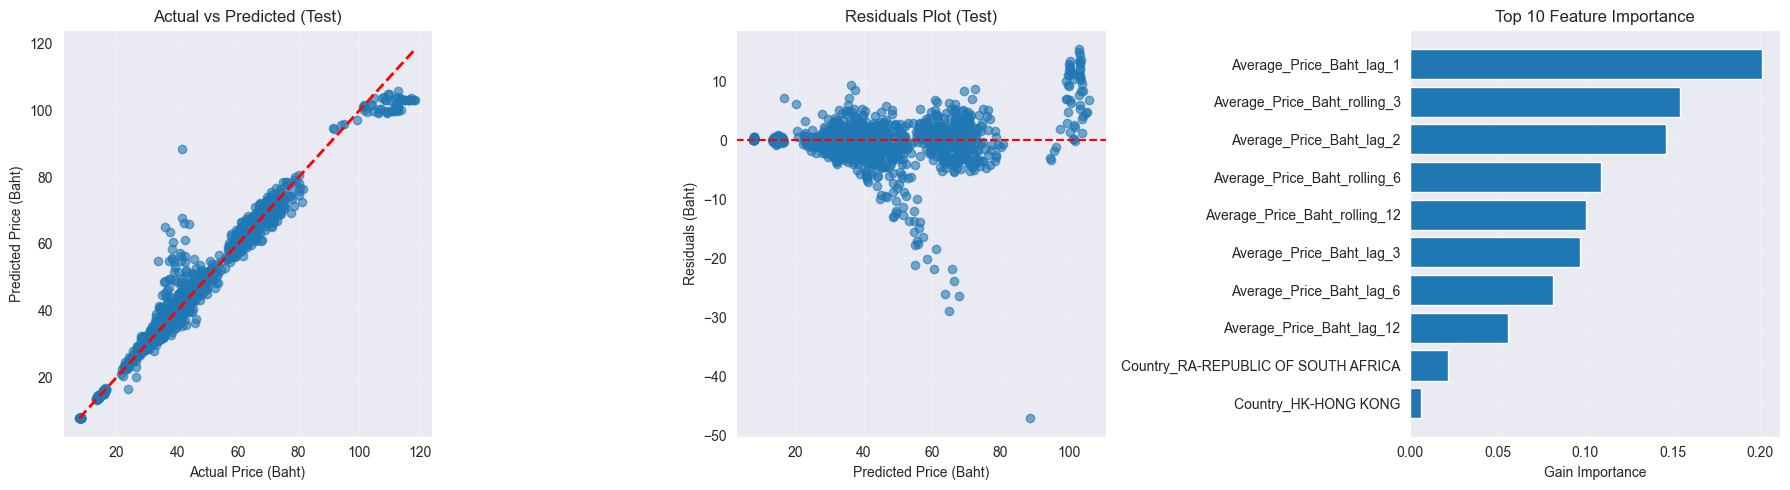

In [15]:
# %%
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1) Actual vs Predicted (Test)
axes[0].scatter(y_test, yte_pred, alpha=0.6)
mn, mx = float(np.min(y_test)), float(np.max(y_test))
axes[0].plot([mn, mx], [mn, mx], 'r--', lw=2)
axes[0].set_xlabel('Actual Price (Baht)')
axes[0].set_ylabel('Predicted Price (Baht)')
axes[0].set_title('Actual vs Predicted (Test)')
axes[0].grid(True, alpha=0.3)

# 2) Residuals (Test)
resid = y_test - yte_pred
axes[1].scatter(yte_pred, resid, alpha=0.6)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted Price (Baht)')
axes[1].set_ylabel('Residuals (Baht)')
axes[1].set_title('Residuals Plot (Test)')
axes[1].grid(True, alpha=0.3)

# 3) Top-10 Feature Importance
topk = fi.head(10).iloc[::-1]  # พลิกให้สำคัญสุดอยู่บน
axes[2].barh(topk["Feature"], topk["Importance"])
axes[2].set_xlabel('Gain Importance')
axes[2].set_title('Top 10 Feature Importance')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [16]:
# %% [markdown]
# ## Save & Load (pickle) + Predict helper for RandomForest
# - เซฟโมเดล RandomForest เป็น .pkl ด้วย joblib
# - เซฟรายชื่อฟีเจอร์ / ข้อมูลพรีโปรเซส / เมตริก / runtime config
# - ฟังก์ชันพยากรณ์: โหลด .pkl → จัดคอลัมน์ให้ตรง → predict

# %%
import os, json
import joblib
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# ====== 0) ตรวจตัวแปรจากขั้นตอนเทรนแล้วหรือยัง ======
required_vars = [
    "rf_model",          # sklearn RandomForestRegressor ที่เทรนแล้ว
    "X_train", "y_train", "X_test", "y_test",
    "feature_cols",      # รายชื่อคอลัมน์ฟีเจอร์ตอนเทรน
    "month_mapping",     # dict แปลงชื่อเดือน -> เลข
    "target_col", "exclude_cols",
    "monthly_data",      # ใช้ดึงรายชื่อประเทศ/ไอเท็มที่มีใน data
    "mae_tr", "rmse_tr", "r2_tr",
    "mae_te", "rmse_te", "r2_te",
]
missing = [v for v in required_vars if v not in globals()]
assert not missing, f"ขาดตัวแปรก่อนเซฟ: {missing}"

# ====== 1) โฟลเดอร์ปลายทาง ======
SAVE_DIR = "Deploy/RandomForest"
os.makedirs(SAVE_DIR, exist_ok=True)

# ====== 2) เซฟโมเดลเป็น pickle (.pkl) ======
model_pkl_path = os.path.join(SAVE_DIR, "oil_price_randomforest_model.pkl")
joblib.dump(rf_model, model_pkl_path)
print(f"[OK] Saved RandomForest model (pickle): {model_pkl_path}")

# ====== 3) เซฟรายชื่อฟีเจอร์ ======
feature_cols_path = os.path.join(SAVE_DIR, "feature_columns.pkl")
joblib.dump(feature_cols, feature_cols_path)
print(f"[OK] Saved feature columns: {feature_cols_path}")

# ====== 4) เซฟ preprocessing info ======
preprocessing_info = {
    "month_mapping": month_mapping,
    "target_column": target_col,
    "exclude_columns": exclude_cols,
    "lag_periods": [1, 2, 3, 6, 12],
    "rolling_windows": [3, 6, 12],
    "countries_included": sorted(monthly_data["Country"].unique().tolist()),
    "items_included": sorted(monthly_data["Item"].unique().tolist()),
    "train_test_split": {"type": "global_time_cutoff_quantile", "quantile": 0.80}
}
prep_path = os.path.join(SAVE_DIR, "preprocessing_info.pkl")
joblib.dump(preprocessing_info, prep_path)
print(f"[OK] Saved preprocessing info: {prep_path}")

# ====== 5) เซฟเมตริกและ Feature Importance ======
# สร้าง feature importance ถ้ายังไม่มี
try:
    fi_rf = pd.DataFrame({"Feature": feature_cols, "Importance": rf_model.feature_importances_})\
                .sort_values("Importance", ascending=False).reset_index(drop=True)
    top_fi = fi_rf.head(10).to_dict("records")
except Exception:
    fi_rf = None
    top_fi = []

model_metrics = {
    "training": {"mae": float(mae_tr), "rmse": float(rmse_tr), "r2": float(r2_tr)},
    "test":     {"mae": float(mae_te), "rmse": float(rmse_te), "r2": float(r2_te)},
    "feature_importance_top10": top_fi
}
metrics_path = os.path.join(SAVE_DIR, "model_metrics.pkl")
joblib.dump(model_metrics, metrics_path)
print(f"[OK] Saved model metrics: {metrics_path}")

# ====== 6) runtime config (ไว้ให้แอปโหลดง่าย) ======
runtime_config = {
    "model_path": os.path.basename(model_pkl_path),
    "feature_cols_path": os.path.basename(feature_cols_path),
    "preprocessing_info_path": os.path.basename(prep_path),
    "metrics_path": os.path.basename(metrics_path),
    "model_type": "RandomForestRegressor"
}
with open(os.path.join(SAVE_DIR, "runtime_config.json"), "w", encoding="utf-8") as f:
    json.dump(runtime_config, f, ensure_ascii=False, indent=2)
print(f"[OK] Saved runtime_config.json")

# ====== 7) ฟังก์ชันพยากรณ์จากไฟล์ .pkl (RandomForest) ======
def load_rf_from_pickle(model_path: str) -> RandomForestRegressor:
    """โหลด RandomForestRegressor ที่เซฟด้วย joblib/pickle"""
    mdl = joblib.load(model_path)
    if not isinstance(mdl, RandomForestRegressor):
        raise TypeError(f"ไฟล์ '{model_path}' ไม่ใช่ RandomForestRegressor")
    return mdl

def predict_oil_price_rf_pickle(
    features_dict: dict,
    model_path: str = model_pkl_path,
    feature_cols_path: str = feature_cols_path
) -> float | None:
    """
    พยากรณ์ราคาน้ำมัน (บาท) ด้วยโมเดล RandomForest ที่เซฟเป็น .pkl

    Parameters
    ----------
    features_dict : dict
        key = ชื่อฟีเจอร์, value = ค่าตัวเลข (รวม one-hot เช่น 'Country_THAILAND':1)
    model_path : str
        path ไปยัง .pkl (RandomForestRegressor)
    feature_cols_path : str
        path ไปยัง .pkl รายชื่อคอลัมน์ฟีเจอร์

    Returns
    -------
    float | None
    """
    try:
        # โหลดโมเดลและรายชื่อคอลัมน์
        mdl = load_rf_from_pickle(model_path)
        feat_cols = joblib.load(feature_cols_path)

        # สร้าง DataFrame 1 แถว และเติมคอลัมน์ที่ขาดด้วย 0
        df_in = pd.DataFrame([features_dict])
        for col in feat_cols:
            if col not in df_in.columns:
                df_in[col] = 0.0
        df_in = df_in[feat_cols]

        # พยากรณ์
        pred = mdl.predict(df_in)
        return float(pred[0])

    except Exception as e:
        print(f"[predict_oil_price_rf_pickle] Error: {e}")
        try:
            print(f"Provided keys: {sorted(list(features_dict.keys()))[:12]} ...")
        except Exception:
            pass
        return None

print("\n=== RandomForest Deployment Summary (pickle) ===")
print(f"Train R²   : {model_metrics['training']['r2']:.4f}")
print(f"Test  R²   : {model_metrics['test']['r2']:.4f}")
print(f"Test  MAE  : {model_metrics['test']['mae']:.4f} Baht")
print(f"Test  RMSE : {model_metrics['test']['rmse']:.4f} Baht")
print(f"Artifacts in '{SAVE_DIR}':")
for fn in sorted(os.listdir(SAVE_DIR)):
    print("  -", fn)

# ตัวอย่างการใช้งาน:
# features = {...}  # dict ของฟีเจอร์ (เติม one-hot ที่จำเป็น)
# price = predict_oil_price_rf_pickle(features)
# print("Predicted price:", price)


[OK] Saved RandomForest model (pickle): Deploy/RandomForest\oil_price_randomforest_model.pkl
[OK] Saved feature columns: Deploy/RandomForest\feature_columns.pkl
[OK] Saved preprocessing info: Deploy/RandomForest\preprocessing_info.pkl
[OK] Saved model metrics: Deploy/RandomForest\model_metrics.pkl
[OK] Saved runtime_config.json

=== RandomForest Deployment Summary (pickle) ===
Train R²   : 0.9549
Test  R²   : 0.9622
Test  MAE  : 2.2766 Baht
Test  RMSE : 4.0688 Baht
Artifacts in 'Deploy/RandomForest':
  - feature_columns.pkl
  - model_metrics.pkl
  - oil_price_randomforest_model.pkl
  - preprocessing_info.pkl
  - runtime_config.json
